Using the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels, to analyze the text and classify the text into one of the 46 classes. Classes are the defined based on the following list (in the same order):
>```
['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']
```

### 1) Processing Data

In [4]:
# Load data

### YOUR CODE HERE ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow as tf
import textwrap
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import reuters 
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM, Bidirectional
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras
from sklearn.metrics import r2_score
from keras.utils import np_utils

max_sequence_len = 800

ds, _ = reuters.load_data(
    maxlen=max_sequence_len,
    test_split=0,
    seed=42,
)

# Clean and pre-process the data
word_dict = tf.keras.datasets.reuters.get_word_index()
word_dict = {k:(v+3) for k,v in word_dict.items()}
word_dict["<PAD>"] = 0
word_dict["<START>"] = 1
word_dict["<UNK>"] = 2
word_dict["<UNUSED>"] = 3
# turn training data into text
inverse_word_dict = {value:key for key,value in word_dict.items()}
vocab_size = len(word_dict.keys())

# encode a paragraph
def encode_review(review, word_dict, maxlen):
  encoded_review = []
  for raw_word in review.split(' '):
    word = raw_word.strip().strip(string.punctuation).lower()
    if word == '' or word == '\n':
      continue
    try:
      encoded_review.append(word_dict[word])
    except KeyError as e:
      # raise KeyError(f'{e} not in word dictionary, review not encoded.')
      continue
  return pad_sequences(np.array(encoded_review).reshape(1,-1), maxlen=maxlen)

# decode a paragraph
def decode_review(encoded_review, inverse_word_dict):
  sentence = []
  for encoded_word in encoded_review:
    if encoded_word == 0:
      continue
    sentence.append(inverse_word_dict[encoded_word])
  w = textwrap.TextWrapper(width=120,break_long_words=False,replace_whitespace=False)
  return '\n'.join(w.wrap(' '.join(sentence)))


# Print sample data
for i in range(5):
  print(decode_review(ds[0][i], inverse_word_dict), "\nCaterory: ", ds[1][i], end="\n\n")
  
print("ds length: ", len(ds[0]))

<START> net 65 mln vs 57 mln year shr preferred 14 87 dlrs vs 12 51 dlrs shr common 236 77 dlrs vs 197 40 dlrs net 247
mln vs 208 mln note federal home loan mortgage corp fhlmc had 14 998 210 preferred shares outstanding in 1986 vs 14 998
379 in 1985 owned by about 3 000 member institutions of the 12 federal home loan banks fhlmc also has 100 000 shares of
common owned by the home loan banks reuter 3 
Caterory:  3

<START> three consecutive days of talks between management and unions aimed at ending the three month old strike at
cargill u k ltd's oilseed processing plant at seaforth ended yesterday without resolving the situation although some
progress was made a company spokesman said fresh talks have been scheduled for next tuesday he said reuter 3 
Caterory:  2

<START> the bank of france said it set a money market intervention tender today to inject funds to the market against
first category paper money market sources said the surprise announcement might herald a quarter percentage

### 2) Data Partitioning

In [5]:
# split data into training and test sets. 
# 80% for training and 20% for test
X_train, X_test, y_train, y_test = train_test_split(ds[0], ds[1], test_size=0.20, random_state=42, shuffle=False)
X_train = pad_sequences(X_train, maxlen=max_sequence_len)
X_test = pad_sequences(X_test, maxlen=max_sequence_len)
y_train = np_utils.to_categorical(y_train, 46)
y_test = np_utils.to_categorical(y_test, 46)

### 3) RNN Model

In [8]:
from tensorflow.keras.layers import GRU 
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(max_sequence_len))
reuters_model = keras.Sequential()
reuters_model.add(Embedding(vocab_size, 128))
reuters_model.add(Bidirectional(LSTM (20)))
reuters_model.add(Dropout(0.3))
reuters_model.add(Dense(46, activation='softmax'))

loss = CategoricalCrossentropy()

opt = RMSprop(learning_rate=0.01)

metrics = 'accuracy'

reuters_model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

reuters_model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         3965824   
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               23840     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 46)                1886      
                                                                 
Total params: 3,991,550
Trainable params: 3,991,550
Non-trainable params: 0
_________________________________________________________________


In [9]:
batchsize = 30
epochs =  20

# Fit model
history = reuters_model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/20
239/239 [==============================] - 167s 682ms/step - loss: 1.9614 - accuracy: 0.5138 - val_loss: 1.7896 - val_accuracy: 0.5912
Epoch 2/20
239/239 [==============================] - 171s 717ms/step - loss: 1.4174 - accuracy: 0.6637 - val_loss: 1.2778 - val_accuracy: 0.6868
Epoch 3/20
239/239 [==============================] - 171s 715ms/step - loss: 1.1312 - accuracy: 0.7311 - val_loss: 1.1986 - val_accuracy: 0.7153
Epoch 4/20
239/239 [==============================] - 172s 721ms/step - loss: 0.9511 - accuracy: 0.7726 - val_loss: 1.1225 - val_accuracy: 0.7472
Epoch 5/20
239/239 [==============================] - 173s 725ms/step - loss: 0.8008 - accuracy: 0.8115 - val_loss: 1.1195 - val_accuracy: 0.7500
Epoch 6/20
239/239 [==============================] - 174s 726ms/step - loss: 0.6813 - accuracy: 0.8416 - val_loss: 1.0880 - val_accuracy: 0.7617
Epoch 7/20
239/239 [==============================] - 173s 723ms/step - loss: 0.5877 - accuracy: 0.8690 - val_loss: 1.0746 -

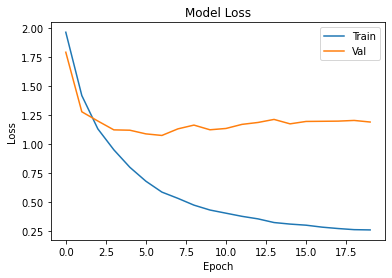

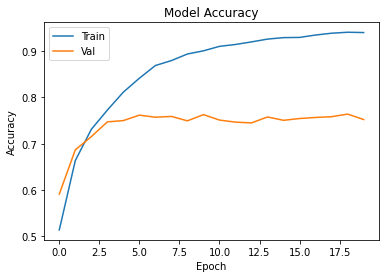

In [10]:
# graph loss and accuracy 
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

plot_losses(history)
plot_accuracies(history)

### 4) Look at the Predictions

70/70 - 8s - loss: 1.2622 - accuracy: 0.7575 - 8s/epoch - 115ms/step
70/70 [==============================] - 10s 125ms/step
Test Loss 1.262171983718872
Test Accuracy 0.7574943900108337
1 :  0.5
2 :  0.8035714285714286
3 :  0.5294117647058824
4 :  0.9338422391857506
5 :  0.8181818181818182
6 :  0.0
7 :  0.875
8 :  0.6666666666666666
9 :  0.6
10 :  0.52
11 :  0.7241379310344828
12 :  0.7319587628865979
13 :  0.42857142857142855
14 :  0.3
15 :  0.0
16 :  0.5
17 :  0.6326530612244898
18 :  1.0
19 :  0.5
20 :  0.6014492753623188
21 :  0.581081081081081
22 :  0.5862068965517241
23 :  0.0
24 :  0.2
25 :  0.5882352941176471
26 :  0.5909090909090909
27 :  0.6666666666666666
28 :  0.0
29 :  0.5
30 :  0.4
31 :  0.6923076923076923
32 :  0.5714285714285714
33 :  0.5714285714285714
34 :  0.4
35 :  0.3333333333333333
36 :  0.0
37 :  0.23529411764705882
38 :  0.0
39 :  0.2
40 :  0.16666666666666666
41 :  0.16666666666666666
42 :  0.2857142857142857
43 :  0.0
44 :  0.75
45 :  0.5
46 :  0.5


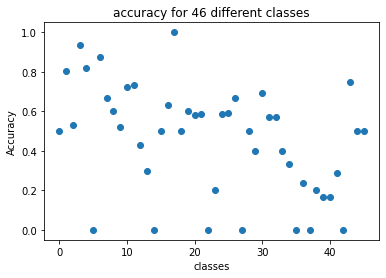

In [11]:
from nltk import FreqDist
loss_and_metrics = reuters_model.evaluate(X_test, y_test, verbose=2)

pred = reuters_model.predict(X_test)

pred = np.argmax(pred, axis = 1)
label = np.argmax(y_test,axis = 1)

freq = FreqDist(label)
all_fdist = dict(freq)

count = [0]*46
for i in range(len(pred)):
  if pred[i] == label[i]:
    count[label[i]] +=1

prob = [0]*46
dist = [0] *46
for i in range(46):
  dist[i] = all_fdist[i]

for i in range(46):
  prob[i] = count[i]/dist[i]

x = range(46)
print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

plt.scatter(x, prob)
plt.title('accuracy for 46 different classes')
plt.ylabel('Accuracy')
plt.xlabel('classes')

for i in range(46):
  print(i+1, ": ", prob[i])